In [1]:
# import Functions 

import numpy as np   # linear algebra
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivety = "all"

import math
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [2]:
# Load the Dataset and Add headers

electronics_data = pd.read_csv("ratings_Electronics_(1)[1].csv", names = ['userId', 'productId', 'Rating', 'timestamp'])
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
electronics_data.shape

(7824482, 4)

In [4]:
# Taking subset of the dataset

electronics_data = electronics_data.iloc[: 1048576, 0:]

In [5]:
# Check the datatypes

electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [6]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [7]:
# Five point summary

electronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [8]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


# Handling Missing values

In [9]:
# Check for missing values
print('Number of missing values across columns: \n', electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


In [10]:
# Check the distribution of Ratings

# with sns.axes_style('white'):
#     g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
#     g.set_ylabels("Total number of ratings")

# Uniqure users and products

In [11]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :", electronics_data.shape[0])
print("Total No of Users  :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048576
Total No of Users  : 786330
Total No of products  : 61894


In [12]:
# Droppint the TimeStamp Column
electronics_data.drop(['timestamp'], axis=1, inplace=True)

# Analyzing the rating

In [13]:
# Analysis of rating given by the user

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [14]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [15]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

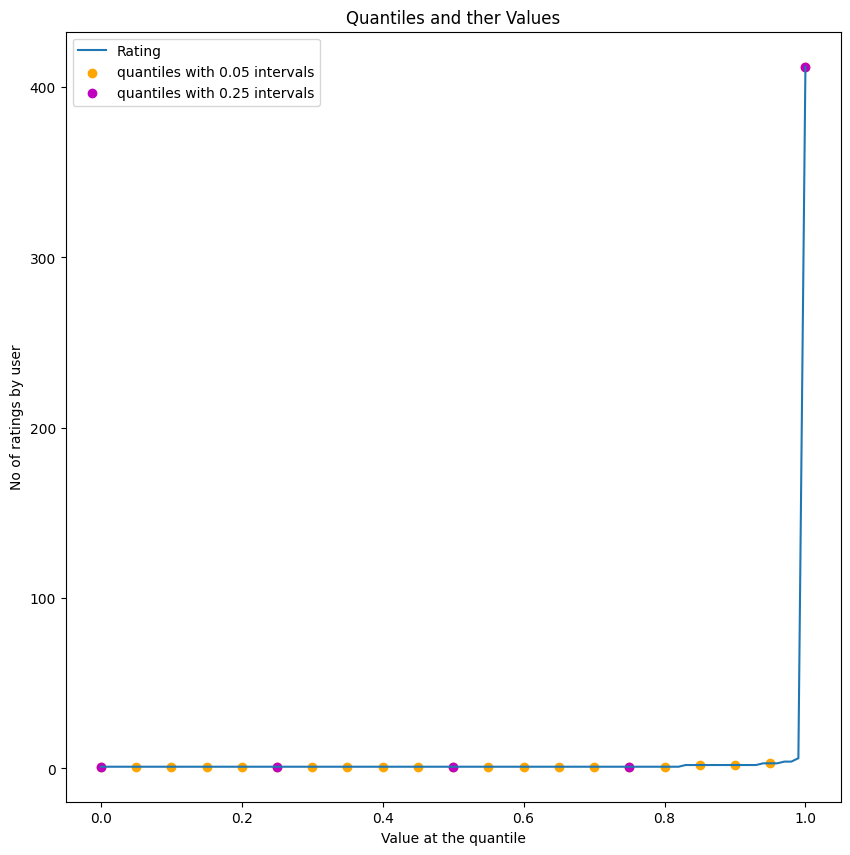

In [16]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and ther Values")
quantiles.plot()

# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")

# prantiles with 0.25 dfference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label="quantiles with 0.25 intervals")

plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [17]:
print('\n No of rated procduct more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)))


 No of rated procduct more than 50 per user : 38



# Popularity Based Recommendation

In [18]:
# Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

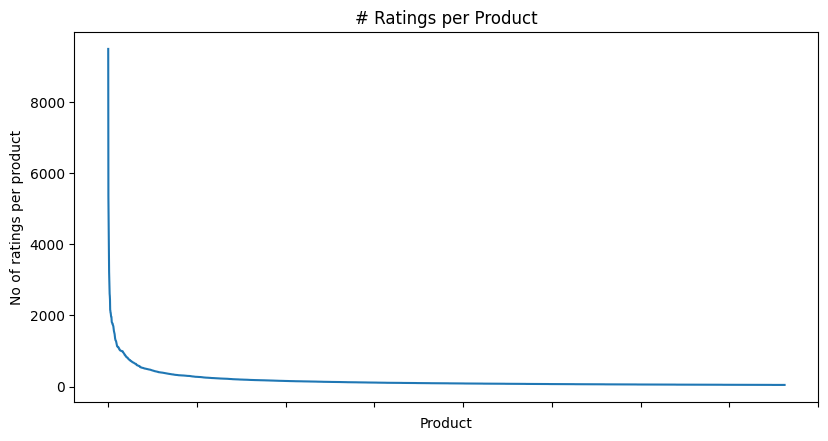

In [19]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# Ratings per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [20]:
# average rating of product

new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [21]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [22]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [23]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [24]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [25]:
ratings_mean_count['rating_counts'].max()

9487

<AxesSubplot: >

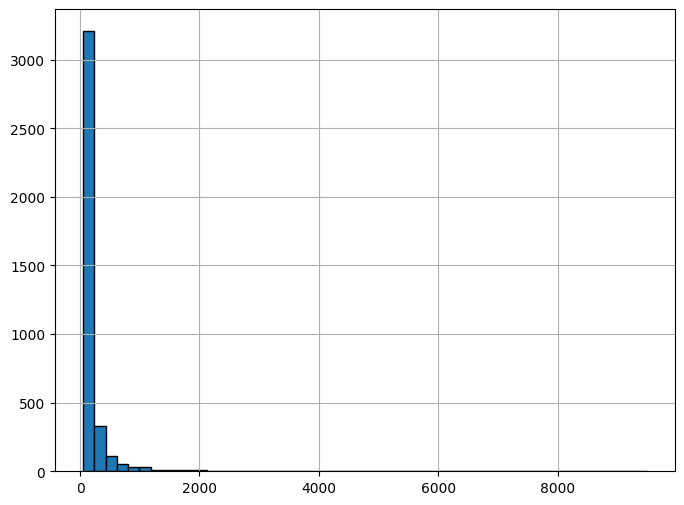

In [26]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<AxesSubplot: >

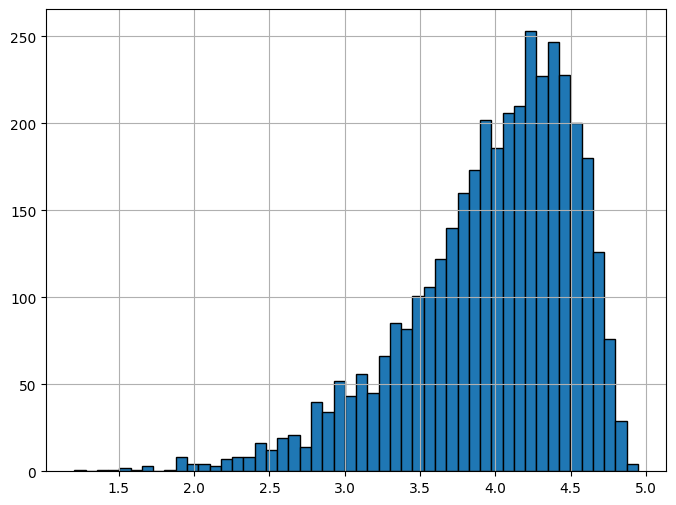

In [27]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# Collaverative filterig (Item-Item recommedation)

In [ ]:
from surprise import KNNWinthMeans
from surprise import Dataset
from surprise import accuracy 
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [ ]:
# Reading the dataset
reader = Reader(rating_scale=(1,5))
data = Dataser.load_from_df(new_df, reader)

In [ ]:
# Splitting the dataset
trainser, testset = train_test_split(data, test_size=0.3, random_state=10)

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering

alg0 = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

In [ ]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [ ]:
test_pred

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

#  

# Model-based collaborative fltering system

In [ ]:
new_df1 = new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

In [ ]:
ratings_matrix.shape

In [ ]:
X = ratings_matrix.T
X.head()

In [ ]:
X.shape

In [ ]:
X1 = X

In [ ]:
# Decomposing the Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape


In [ ]:
X.index[75]


In [ ]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]